In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import dspy
from dspy.datasets import DataLoader
from dspy.adapters.vllm_adapter import encode_image
from dspy.teleprompt import LabeledFewShot
from dspy.evaluate import Evaluate
from dspy.evaluate.metrics import answer_exact_match

2024-09-16 22:35:25.450694: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 22:35:25.507478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 22:35:25.507500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 22:35:25.510298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 22:35:25.520454: I tensorflow/core/platform/cpu_feature_guar

In [20]:
lm = dspy.LM(model="openai/Qwen/Qwen2-VL-7B-Instruct", api_base="http://localhost:8000/v1", api_key="sk-proj-1234567890")

# adapter = dspy.ChatAdapter()
dspy.settings.configure(lm=lm)

In [5]:


input_keys = tuple([f"image_{i}" for i in range(1, 8)] + ["question", "options"])
subsets = ['Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art', 'Art_Theory', 'Basic_Medical_Science', 'Biology', 'Chemistry', 'Clinical_Medicine', 'Computer_Science', 'Design', 'Diagnostics_and_Laboratory_Medicine', 'Economics', 'Electronics', 'Energy_and_Power', 'Finance', 'Geography', 'History', 'Literature', 'Manage', 'Marketing', 'Materials', 'Math', 'Mechanical_Engineering', 'Music', 'Pharmacy', 'Physics', 'Psychology', 'Public_Health', 'Sociology']

devset = []
valset = []
for subset in subsets:
    devset.extend(DataLoader().from_huggingface("MMMU/MMMU", subset, split=["dev"], input_keys=input_keys)["dev"])
    valset.extend(DataLoader().from_huggingface("MMMU/MMMU", subset, split=["validation"], input_keys=input_keys)["validation"])

In [6]:
class MMMUSignature(dspy.Signature):
    """
    A multiple choice question about an image.
    """

    question = dspy.InputField(desc="A question about the image(s)")
    image_1 = dspy.InputField(desc="An image of a math problem")
    image_2 = dspy.InputField(desc="An image of a math problem")
    image_3 = dspy.InputField(desc="An image of a math problem")
    image_4 = dspy.InputField(desc="An image of a math problem")
    image_5 = dspy.InputField(desc="An image of a math problem")
    image_6 = dspy.InputField(desc="An image of a math problem")
    image_7 = dspy.InputField(desc="An image of a math problem")
    options = dspy.InputField(desc="The options to the question")
    answer = dspy.OutputField(desc="The answer to the question")

predictor = dspy.Predict(MMMUSignature, temperature=0.0)
# print(predictor(question="What is the capital of france?"))

In [21]:
sample_input=devset[0]
x = predictor(**sample_input.inputs())
print(x)

Prediction(
    rationale='The missing amount for company B is the sum of revenues and expenses. We can calculate this by adding the given values for revenues and expenses for company B. The sum of revenues is $1,480,500 and the sum of expenses is $1,518,300. Therefore, the missing amount is $1,480,500 + $1,518,300 = $2,998,800.',
    answer='$2,998,800'
)


In [22]:
# print(len(devset))
# print(devset)

optimizer = LabeledFewShot(k=3)
bootstrapped_predictor = optimizer.compile(predictor, trainset=devset, sample=False)
# print(sample_input.inputs())
# print(encode_image(sample_input.inputs()["image_1"]))
# print(sample_input.inpi)
# print(bootstrapped_predictor(**sample_input.inputs()))

evaluate = Evaluate(metric=answer_exact_match, num_threads=300, devset= valset, display_progress=True)
print(evaluate(bootstrapped_predictor))

Average Metric: 0.0 / 4  (0.0):   0%|          | 4/900 [01:20<2:44:56, 11.05s/it]

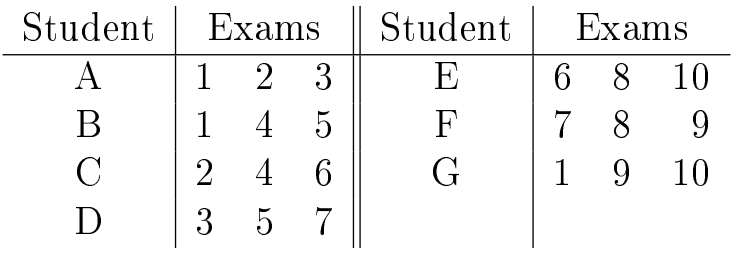

In [ ]:
test_input = dataset["dev"][0]
test_input